# Models

This notebook will demonstrate the basic features of AutoMPC for system ID modeling and model evaluation.

## Set-Up

As before, we begin by importing autompc.

In [2]:
import autompc as ampc

To perform system identification, we need a dataset of trajectories to work with.  We will use the cartpole system, available from the `benchmarks` package, to generate our dataset.

In [3]:
from autompc.benchmarks import CartpoleSwingupBenchmark

benchmark = CartpoleSwingupBenchmark()

system = benchmark.system
trajs = benchmark.gen_trajs(seed=100, n_trajs=100, traj_len=200)
test_trajs = benchmark.gen_trajs(seed=101, n_trajs=100, traj_len=200)

Let's import some useful utilities for debugging, as well.  Here, we'll plot one of the training trajectories and some statistics about the overall training set.

/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 0.14ubuntu0.2 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


[]

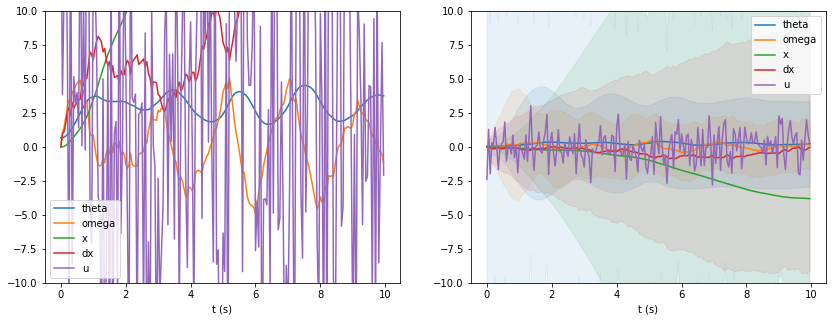

In [4]:
%matplotlib inline
from autompc.sysid.metrics import get_model_rmse
from autompc.graphs import plot_traj,plot_traj_projected,plot_simulation,plot_rollout,plot_trajs
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

plot_traj(trajs[0],ax=ax1)
#plot_traj_projected(trajs[0],ax=ax1)
ax1.set_ylim(-10,10)
plot_trajs(trajs,style='confidence',ax=ax2)
ax2.set_ylim(-10,10)
plt.plot()

## Models

AutoMPC provides a variety of sytem ID models which can be used to learn the sytem dynamics.  Here, we will use an Multi-Layer Perceptron (MLP) neural network model, but for a complete list see [here](https://autompc.readthedocs.io/en/latest/source/sysid.html#supported-system-id-models).

You can examine the hyperparameters used for training using `get_config()` and change them using `set_hyper_values()`, as shown below.  Here we'll change batch normalization to false and the number of hidden layers in the neural net.

(**Note:** This will take several minutes to run depending on your hardware).

In [5]:
from autompc.sysid import MLP

model = MLP(system)
print("Original hyperparameter configuration")
print(model.get_config())                    #prints the hyperparameters of the model
model.set_hyper_values(batchnorm=False)      #modifies the hyperparameters
model.set_hyper_values(n_hidden_layers='3')  #modifies the hyperparameters
print("Modified hyperparameter configuration")
print(model.get_config())                    #prints the hyperparameters of the model

assert model.is_trained == False
model.train(trajs)                           #performs training
assert model.is_trained == True

Original hyperparameter configuration
Configuration:
  batchnorm, Value: False
  hidden_size_1, Value: 128
  hidden_size_2, Value: 128
  lr, Value: 0.001
  n_hidden_layers, Value: '2'
  nonlintype, Value: 'relu'

Modified hyperparameter configuration
Configuration:
  batchnorm, Value: False
  hidden_size_1, Value: 128
  hidden_size_2, Value: 128
  hidden_size_3, Value: 128
  lr, Value: 0.0010000000000000002
  n_hidden_layers, Value: '3'
  nonlintype, Value: 'relu'

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


When manually training models like this, it is a good idea to inspect your training and testing error. You can do so with some convenience methods in AutoMPC.  The below code will compute the Root-Mean-Squared Error (RMSE) and also plot a rollout of the model, using the initial state and controls from a sample trajectory

MLP 1-step RMSE on training set: 0.019542403063667228
MLP 1-step RMSE on testing set: 0.0990494549763112


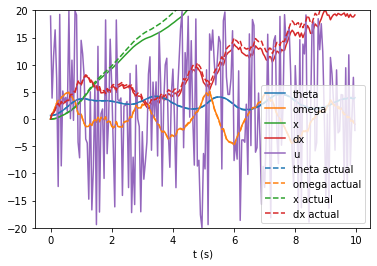

In [6]:
print("MLP 1-step RMSE on training set:",get_model_rmse(model,trajs))
print("MLP 1-step RMSE on testing set:",get_model_rmse(model,test_trajs))

plot_rollout(trajs[0],model)
plt.ylim([-20,20])
plt.show()

Now that we have trained our model, we can use it to make predictions.  Let's try predicting the next state from one of our training trajectories.  We first compute the model state at a certain point in the trajectory

In [7]:
traj = trajs[0]
model_state = model.traj_to_state(traj[:100])

The model state contains the information the model needs to predict the next time step.  `model_state[:system.obs_dim]` is always equal to the most recent observation.  For the MLP, that's actually all there is to the model state, but some models require a larger state.  We can see the dimension of the model state by running

In [8]:
model.state_dim

4

We can also check other properties of the model, such as whether it is differentiable and whether it is linear.

In [9]:
print("Model is Differentiable? ", model.is_diff)
print("Model is Linear? ", model.is_linear)

Model is Differentiable?  True
Model is Linear?  False


For comparison, consider the ARX model.  

ARX 1-step RMSE on training set: 0.3233420636353531
ARX 1-step RMSE on testing set: 0.3337771749434752


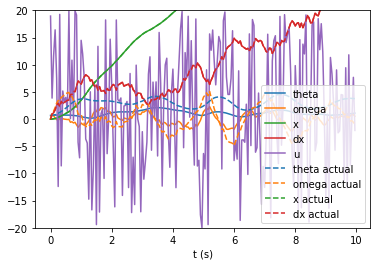

In [10]:
from autompc.sysid import ARX

model_arx = ARX(system)
model_arx.train(trajs)

print("ARX 1-step RMSE on training set:",get_model_rmse(model_arx,trajs))
print("ARX 1-step RMSE on testing set:",get_model_rmse(model_arx,test_trajs))

plot_rollout(trajs[0],model_arx)
plt.ylim([-20,20])
plt.show()

We observe that, unlike the MLP model, the ARX model state size is larger than `system.obs_dim` since the model state includes the history of several observations.  Make sure to use the `traj_to_state` method to properly derive the model state.  We can also observe that the ARX model is linear, which means that it is suitable for use with LQR control.

In [11]:
model_state_arx = model_arx.traj_to_state(traj[:100])
model_arx.state_dim

20

In [12]:
model_arx.is_linear

True

We can use our current model state, and the control to make a prediction of the new model state

In [13]:
pred_state = model.pred(model_state, traj[99].ctrl)
pred_state

array([ 2.41131604,  4.06037243, 27.23860003,  7.63558179])

Compare this to the true observation

In [14]:
traj[100].obs

array([ 2.41170398,  4.04120632, 27.2465825 ,  7.66062691])

We can use the true observation to update our model state

In [15]:
new_model_state = model.update_state(model_state, traj[99].ctrl, traj[100].obs)
new_model_state

array([ 2.41170398,  4.04120632, 27.2465825 ,  7.66062691])

For differentiable models, we can also get the Jacobian of the
model prediction

In [16]:
pred_state, state_jac, ctrl_jac = model.pred_diff(model_state, traj[99].ctrl)
state_jac

array([[ 1.00100531e+00,  5.15019911e-02, -4.17261844e-05,
         9.93395179e-05],
       [ 6.07160361e-01,  9.40099011e-01,  5.39587604e-05,
        -4.06900588e-03],
       [-9.53888107e-03,  4.44717679e-03,  1.00013270e+00,
         5.11386984e-02],
       [ 9.61670252e-03, -7.65000205e-03,  5.58926411e-04,
         9.96767381e-01]])

## Graphing Model Accuracy

Now, we'd like to compare ARX to our original model.  One convenient way to do this is by graphing the model prediction error over various prediction horizons.  AutoMPC provides tools for easily constructing this graph.  (**Note:** This may take a few minutes to run)

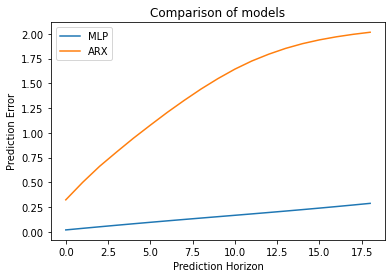

In [21]:
import matplotlib.pyplot as plt
from autompc.graphs import KstepPredAccGraph

graph = KstepPredAccGraph(system, trajs, kmax=20, metric="rmse")
graph.add_model(model, "MLP")
graph.add_model(model_arx, "ARX")

fig = plt.figure()
ax = fig.gca()
graph(fig, ax)
ax.set_title("Comparison of models")
plt.show()

We can see that the MLP has much lower prediction error than the ARX, and that the prediction error of both models increases with the horizon.  Here the system timestep is 0.05s, so the end of the plot is about 1 second in the future.

Another thing that we often like to do is to compare the rollouts of two methods. We can do so using the `plot_traj` method multiple times on the trajectory prediction error, as shown below. It can be seen that ARX does a better job in very long-term prediction particularly on the x and dx observations, whereas MLP does a better job on short-range prediction.

[]

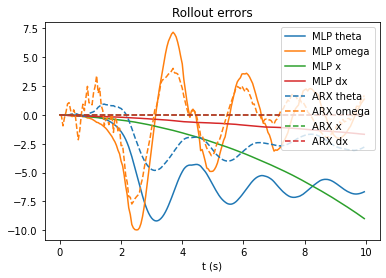

In [22]:
#compute rollout errors
from autompc.utils import rollout

index = 3
#dims = ['x']
dims = None
traj_mlp = rollout(model,trajs[index])
traj_arx = rollout(model_arx,trajs[index])
mlp_err = traj_mlp-trajs[index]
arx_err = traj_arx-trajs[index]
plot_traj(mlp_err,obs_opts=[{'label':'MLP '+x} for x in traj_mlp.system.observations],ctrl_opts=False,dims=dims)
plot_traj(arx_err,obs_opts=[{'label':'ARX '+x,'linestyle':'--'} for x in traj_arx.system.observations],ctrl_opts=False,dims=dims)
plt.title("Rollout errors")
plt.plot()

[]

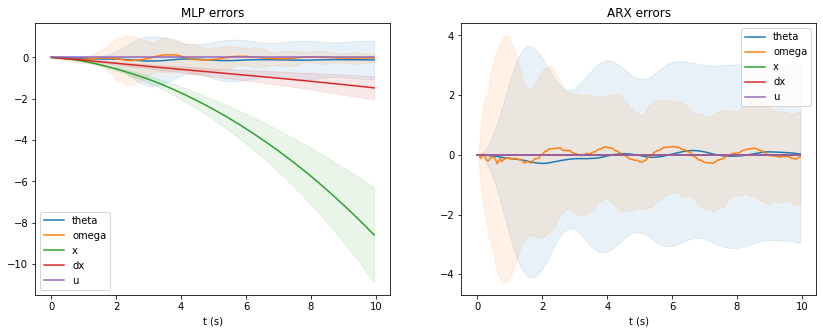

In [19]:
#compute data set of errors and plot stats for both models
errs_mlp = [None]*len(trajs)
errs_arx = [None]*len(trajs)
for i in range(len(trajs)):
    errs_mlp[i] = rollout(model,trajs[i])-trajs[i]
    errs_arx[i] = rollout(model_arx,trajs[i])-trajs[i]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))

plot_trajs(errs_mlp,style='confidence',ctrl_opts=False,ax=ax1)
plot_trajs(errs_arx,style='confidence',ctrl_opts=False,ax=ax2)
ax1.set_title("MLP errors")
ax2.set_title("ARX errors")
plt.plot()